# 🖥️ Choosing an appropriate timestep and integrator 

In this guide, we explore the 

```{note}
TODO: write notebook describing how to use `dt` and integration methods in Kernels to control numerical accuracy. Use [Michaels tutorial](https://github.com/Parcels-code/10year-anniversary-session2/blob/main/advection_and_windage.ipynb) as a starting point.
```

- convergence of integration (sample particles, full length of simulation)
- Realizations vs distributions
- dt from flow simulation (linear interpolation in time, aliasing)
- dt from CFD condition
- Lagrangian analysis vs Lagrangian modelling?

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import parcels

/var/folders/fd/p7j_05zx409dzmtfjjjnjgfh0000gn/T/ipykernel_23854/2983398643.py:5: UserWarning: This is an alpha version of Parcels v4. The API is not stable and may change without deprecation warnings.
  import parcels


# FieldSet temporal resolution
Here we load the daily data

In [2]:
# Load the CopernicusMarine data in the Agulhas region from the example_datasets
example_dataset_folder = parcels.download_example_dataset(
    "CopernicusMarine_data_for_Argo_tutorial"
)

ds_fields = xr.open_mfdataset(f"{example_dataset_folder}/*.nc", combine="by_coords")
ds_fields.load()  # load the dataset into memory
np.diff(ds_fields.time.values).astype("timedelta64[h]")

array([24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24],
      dtype='timedelta64[h]')

dx/dy, U =

In [3]:
np.diff(ds_fields.latitude.values)

array([0.08333588, 0.08333206, 0.08333206, 0.08333588, 0.08333206,
       0.08333206, 0.08333588, 0.08333206, 0.08333206, 0.08333588,
       0.08333206, 0.08333206, 0.08333588, 0.08333206, 0.08333206,
       0.08333588, 0.08333206, 0.08333206, 0.08333588, 0.08333206,
       0.08333206, 0.08333588, 0.08333206, 0.08333206, 0.08333588,
       0.08333206, 0.08333206, 0.08333588, 0.08333206, 0.08333206,
       0.08333588, 0.08333206, 0.08333206, 0.08333588, 0.08333206,
       0.08333206], dtype=float32)

In [4]:
np.nanmean(np.hypot(ds_fields["uo"].values[:,0,:,:],ds_fields["vo"].values[:,0,:,:]))

np.float32(0.27884468)

In [5]:
fieldset = parcels.FieldSet.from_copernicusmarine(ds_fields)

INFO: cf_xarray found variable 'uo' with CF standard name 'eastward_sea_water_velocity' in dataset, renamed it to 'U' for Parcels simulation.
INFO: cf_xarray found variable 'vo' with CF standard name 'northward_sea_water_velocity' in dataset, renamed it to 'V' for Parcels simulation.


In [6]:
# Particle locations and initial time
npart = 5  # number of particles to be released
initial_release_lons = 32 * np.ones(npart)
initial_release_lats = np.linspace(-32.5, -32, npart, dtype=np.float32)
initial_release_times = np.repeat(
    ds_fields.time.values[0], npart
)  # release all particles at the start time of the fieldset
initial_release_zs = np.repeat(ds_fields.depth.values[0], npart)

In [7]:
# Simulation settings
# # Create a list of different advection timesteps to use
dt_choices = [np.timedelta64(12,"h"), np.timedelta64(6,"h"), np.timedelta64(1,"h"), np.timedelta64(20,"m"), np.timedelta64(5,"m")]
runtime = np.timedelta64(7,"D")    # Total simulation time

for dt in dt_choices:
    pset = parcels.ParticleSet(fieldset=fieldset, pclass=parcels.Particle,
                               time=initial_release_times,
                               z=initial_release_zs,
                               lat=initial_release_lats,
                               lon=initial_release_lons,
                               )
    outputdt = dt
    chunks = int(runtime/outputdt) # Because we will store a lot of positions, to speed up our simulation we need to chunk the output datafile
    
    pfile = parcels.ParticleFile(store=f"output/AdvectionRK2_dt_{int(dt/np.timedelta64(1,"s"))}s.zarr", outputdt=outputdt, chunks=(len(pset), chunks))

    print(f"Begin simulation for (scheme: AdvectionRK2, dt={int(dt/np.timedelta64(1,"s"))} s)")
    pset.execute(parcels.kernels.AdvectionRK2, runtime=runtime, dt=dt, output_file=pfile)

Begin simulation for (scheme: AdvectionRK2, dt=43200 s)
INFO: Output files are stored in /Users/Gebruiker/Documents/UU/parcels/Parcels/docs/user_guide/examples/output/AdvectionRK2_dt_43200s.zarr
Integration time: 2024-01-07T12:00:00.000000000: 100%|██████████| 604800.0/604800.0 [00:00<00:00, 4530131.45it/s]
Begin simulation for (scheme: AdvectionRK2, dt=21600 s)
INFO: Output files are stored in /Users/Gebruiker/Documents/UU/parcels/Parcels/docs/user_guide/examples/output/AdvectionRK2_dt_21600s.zarr
Integration time: 2024-01-07T18:00:00.000000000: 100%|██████████| 604800.0/604800.0 [00:00<00:00, 3531578.33it/s]
Begin simulation for (scheme: AdvectionRK2, dt=3600 s)
INFO: Output files are stored in /Users/Gebruiker/Documents/UU/parcels/Parcels/docs/user_guide/examples/output/AdvectionRK2_dt_3600s.zarr
Integration time: 2024-01-07T23:00:00.000000000: 100%|██████████| 604800.0/604800.0 [00:00<00:00, 700834.62it/s]
Begin simulation for (scheme: AdvectionRK2, dt=1200 s)
INFO: Output files ar

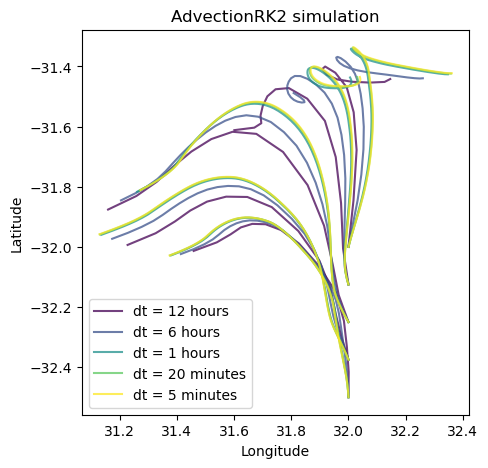

In [8]:
# Create a linear colour map for the different timesteps and load the different datasets to visualise the different trajectories
dt_colours = np.linspace(0,1,len(dt_choices), endpoint=True)

# Construct the figure
plt.figure(figsize=(5,5))
plt.title('AdvectionRK2 simulation')
for i, dt in enumerate(dt_choices):
    ds = xr.open_zarr(f"output/AdvectionRK2_dt_{int(dt/np.timedelta64(1,"s"))}s.zarr")
    labels = [f"dt = {str(dt)}"] + [None] * (ds.lon.shape[0] - 1)
    plt.plot(ds.lon.T, ds.lat.T, alpha=0.75, color=plt.cm.viridis(dt_colours[i]), label=labels)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
plt.legend()
plt.show()

In [9]:
advection_schemes = [parcels.kernels.AdvectionEE, parcels.kernels.AdvectionRK2, parcels.kernels.AdvectionRK4]

In [10]:
for advection_scheme in advection_schemes:
    for dt in dt_choices:
        pset = parcels.ParticleSet(fieldset=fieldset, pclass=parcels.Particle,
                                time=initial_release_times,
                                z=initial_release_zs,
                                lat=initial_release_lats,
                                lon=initial_release_lons,
                                )
        outputdt = dt
        # chunks = int(runtime/outputdt) # Because we will store a lot of positions, to speed up our simulation we need to chunk the output datafile
        
        pfile = parcels.ParticleFile(store=f"output/{advection_scheme.__name__}_dt_{int(dt/np.timedelta64(1,"s"))}s.zarr", outputdt=outputdt) #, chunks=(len(pset), chunks)

        print(f"Begin simulation for (scheme: {advection_scheme.__name__}, dt={int(dt/np.timedelta64(1,"s"))} s)")
        pset.execute(advection_scheme, runtime=runtime, dt=dt, output_file=pfile)
        # print(f"chunks = {(len(pset), chunks)}")

Begin simulation for (scheme: AdvectionEE, dt=43200 s)
INFO: Output files are stored in /Users/Gebruiker/Documents/UU/parcels/Parcels/docs/user_guide/examples/output/AdvectionEE_dt_43200s.zarr
Integration time: 2024-01-07T12:00:00.000000000: 100%|██████████| 604800.0/604800.0 [00:00<00:00, 3589953.59it/s]
Begin simulation for (scheme: AdvectionEE, dt=21600 s)
INFO: Output files are stored in /Users/Gebruiker/Documents/UU/parcels/Parcels/docs/user_guide/examples/output/AdvectionEE_dt_21600s.zarr
Integration time: 2024-01-07T18:00:00.000000000: 100%|██████████| 604800.0/604800.0 [00:00<00:00, 1640317.59it/s]
Begin simulation for (scheme: AdvectionEE, dt=3600 s)
INFO: Output files are stored in /Users/Gebruiker/Documents/UU/parcels/Parcels/docs/user_guide/examples/output/AdvectionEE_dt_3600s.zarr
Integration time: 2024-01-07T23:00:00.000000000: 100%|██████████| 604800.0/604800.0 [00:02<00:00, 274246.76it/s]
Begin simulation for (scheme: AdvectionEE, dt=1200 s)
INFO: Output files are store

In [11]:
# To compare the results visually, we will need distinct colour maps for each advection scheme and timestep
dt_colours = np.linspace(0,1,len(dt_choices), endpoint=True)
scheme_colours = np.linspace(0,1,len(advection_schemes), endpoint=True)

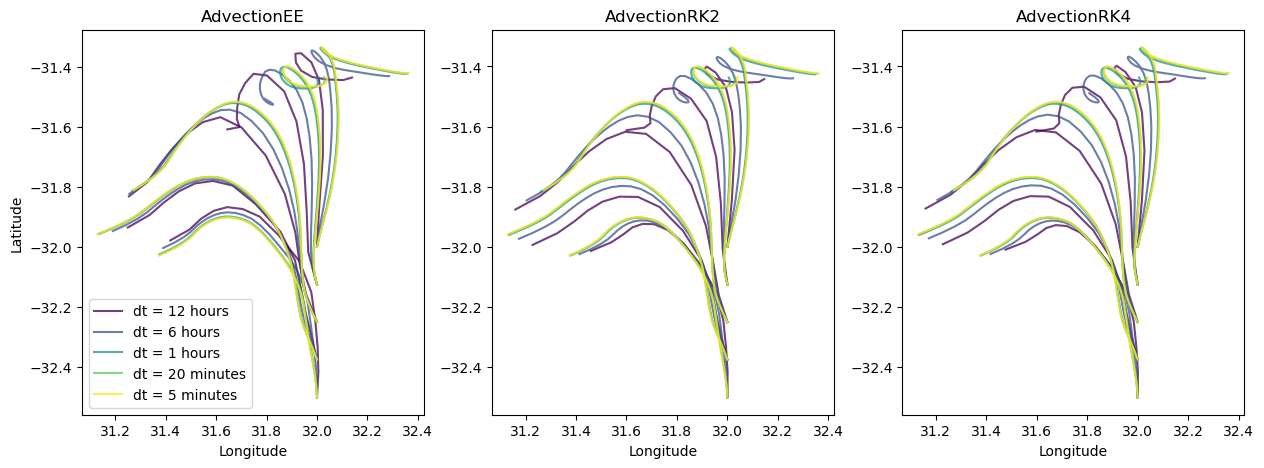

In [12]:
# Let's first compare different timesteps within each advection scheme
fig, axs = plt.subplots(nrows=1, ncols=len(advection_schemes), figsize=(15,5))
for i, advection_scheme in enumerate(advection_schemes):
    axs[i].set_title(f'{advection_scheme.__name__}')
    axs[i].set_xlabel('Longitude')
    for j,dt in enumerate(dt_choices):
        ds = xr.open_zarr(f"output/{advection_scheme.__name__}_dt_{int(dt/np.timedelta64(1,"s"))}s.zarr")
        labels = [f"dt = {str(dt)}"] + [None] * (ds.lon.shape[0] - 1)
        axs[i].plot(ds.lon.T, ds.lat.T, alpha=0.75, color=plt.cm.viridis(dt_colours[j]), label=labels)
    axs[0].legend()
    axs[0].set_ylabel('Latitude')
    #plt.legend()
plt.show()

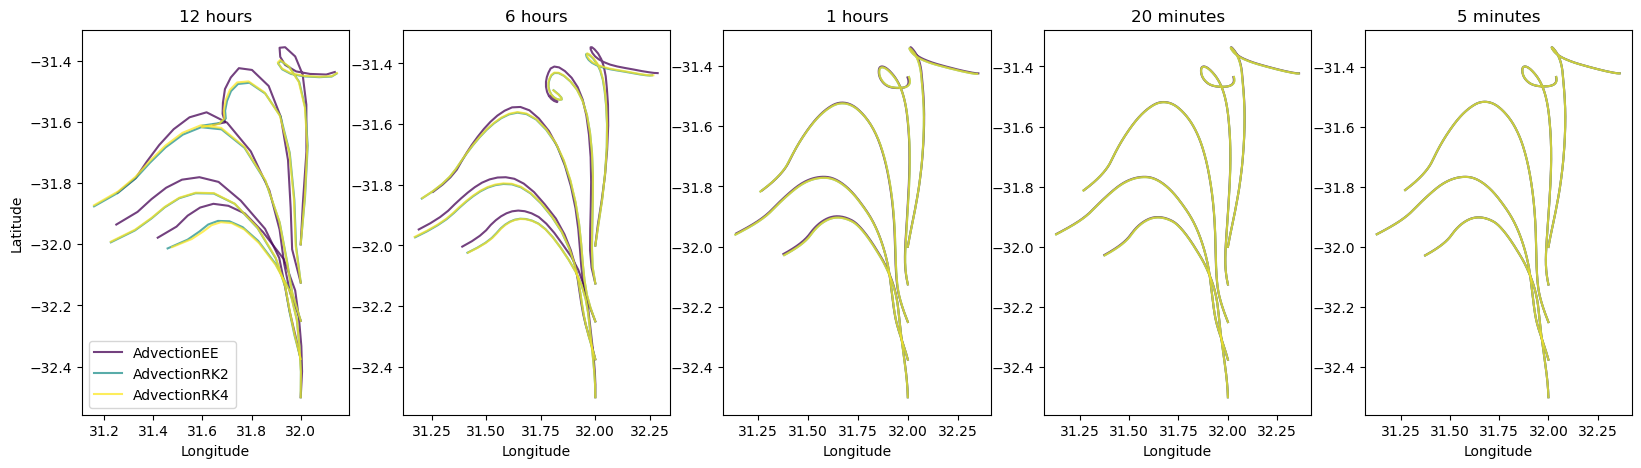

In [13]:
# Now let's compare different advection schemes with the same timestep
fig, axs = plt.subplots(nrows=1, ncols=len(dt_choices), figsize=(20,5))
for i, dt in enumerate(dt_choices):
    axs[i].set_title(f'{str(dt)}')
    axs[i].set_xlabel('Longitude')
    for j,advection_scheme in enumerate(advection_schemes):
        ds = xr.open_zarr(f"output/{advection_scheme.__name__}_dt_{int(dt/np.timedelta64(1,"s"))}s.zarr")
        labels = [f"{advection_scheme.__name__}"] + [None] * (ds.lon.shape[0] - 1)
        axs[i].plot(ds.lon.T, ds.lat.T, alpha=0.75, color=plt.cm.viridis(scheme_colours[j]), label=labels)
    axs[0].legend()
    axs[0].set_ylabel('Latitude')
    #plt.legend()
plt.show()

## Accuracy: advection schemes
Compare with AdvectionRK4. Lagrangian Diagnostics. Great Circle Distance. 

Integration scheme = O(1) error -> Finite Size Lyapunov Exponent takes over.

In [14]:
def dist_km(lona, lonb, lata, latb):
    """
    Function to calculate the distance between 2 points in km
    Haversine formula used, which assumes the Earth is a sphere.
    source: https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
    """

    R = 6371.0 # approximate radius of earth in km

    lat1 = np.radians(lata)
    lon1 = np.radians(lona)
    lat2 = np.radians(latb)
    lon2 = np.radians(lonb)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.atan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c

    return distance

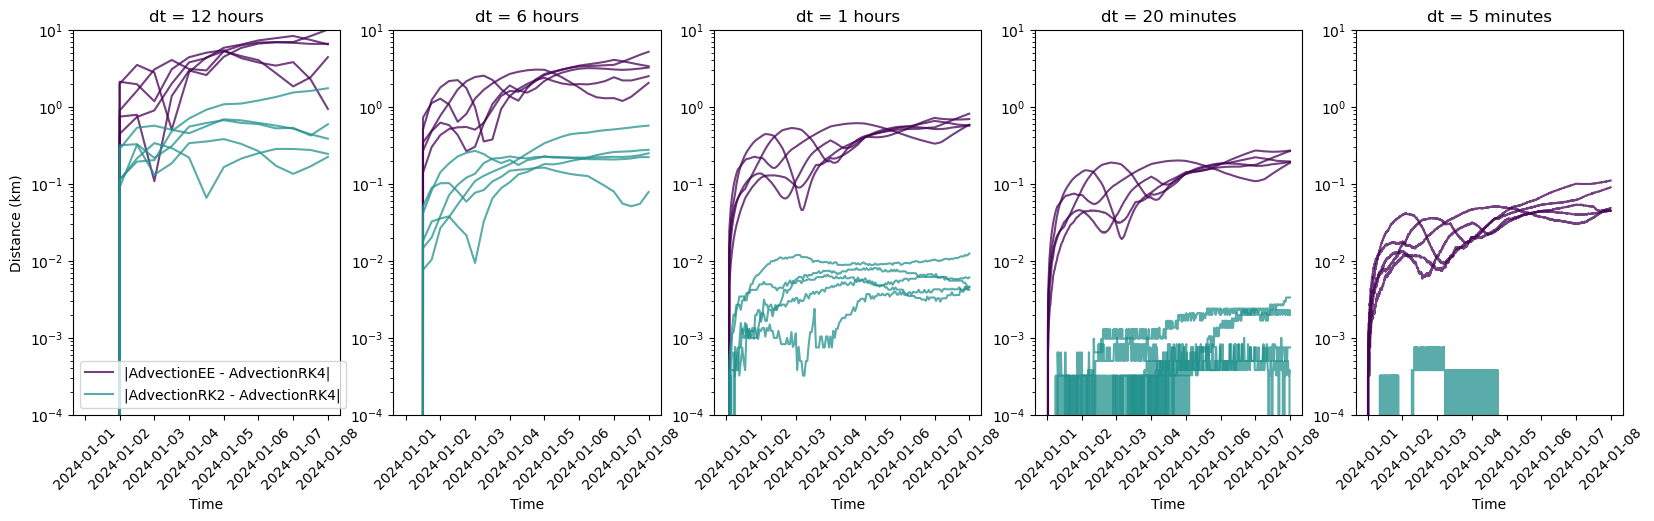

In [15]:
dist_end = np.zeros((len(advection_schemes)-1,len(dt_choices), npart))
# Now let's compare different advection schemes with the same timestep
fig, axs = plt.subplots(nrows=1, ncols=len(dt_choices), figsize=(20,5))
for i, dt in enumerate(dt_choices):
    axs[i].set_title(f'dt = {str(dt)}')
    axs[i].set_xlabel('Time')
    axs[i].tick_params("x", rotation=45)
    axs[i].set_yscale("log")
    axs[i].set_ylim(1e-4,1e1)
    ds_RK4 = xr.open_zarr(f"output/AdvectionRK4_dt_{int(dt/np.timedelta64(1,"s"))}s.zarr")
    for j,advection_scheme in enumerate(advection_schemes[:-1]):
        ds = xr.open_zarr(f"output/{advection_scheme.__name__}_dt_{int(dt/np.timedelta64(1,"s"))}s.zarr")
        labels = [f"|{advection_scheme.__name__} - AdvectionRK4|"] + [None] * (ds.lon.shape[0] - 1)
        dist = dist_km(ds.lon,ds_RK4.lon,ds.lat,ds_RK4.lat)
        axs[i].plot(ds.time.T, dist.T, alpha=0.75, color=plt.cm.viridis(scheme_colours[j]), label=labels)
        dist_end[j,i] = dist[:,-1]
    axs[0].legend()
    axs[0].set_ylabel('Distance (km)')
plt.show()

dx = 1/12 degree ~ 8.3 km

In [16]:
U = 0.1 # m/s
for i, dt in enumerate(dt_choices):
    print(f"{str(dt)} - > error {U*int(dt/np.timedelta64(1,"s"))/1e3} km") 

12 hours - > error 4.32 km
6 hours - > error 2.16 km
1 hours - > error 0.36 km
20 minutes - > error 0.12 km
5 minutes - > error 0.03 km


## Mean separation distance after 7 days

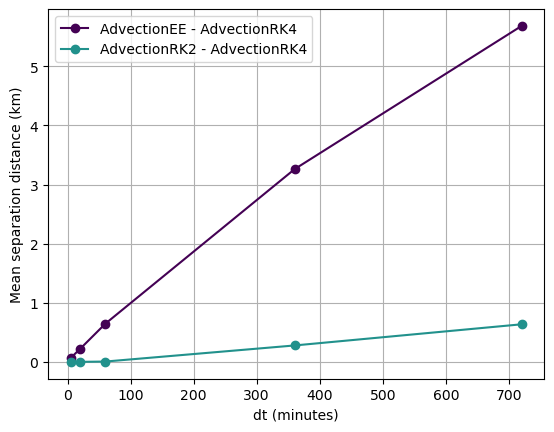

In [17]:
fig = plt.figure()
ax=plt.axes()
ax.plot((dt_choices/np.timedelta64(1,"m")).astype(int), np.mean(dist_end[0],axis=1), "-o", color=plt.cm.viridis(scheme_colours[0]), label = "AdvectionEE - AdvectionRK4")
ax.plot((dt_choices/np.timedelta64(1,"m")).astype(int), np.mean(dist_end[1],axis=1), "-o", color=plt.cm.viridis(scheme_colours[1]), label = "AdvectionRK2 - AdvectionRK4")
ax.set_ylabel("Mean separation distance (km)")
ax.set_xlabel("dt (minutes)")
ax.legend()
ax.grid()
plt.show()

## Converging timesteps

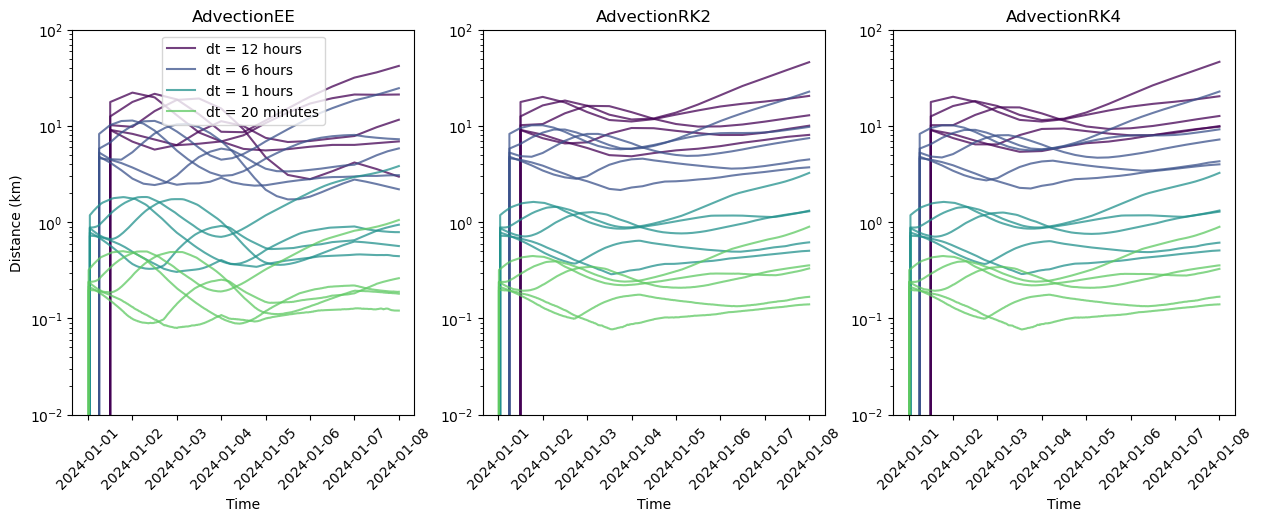

In [ ]:
dist_end = np.zeros((len(dt_choices)-1, len(advection_schemes), npart))
# Let's first compare different timesteps within each advection scheme
fig, axs = plt.subplots(nrows=1, ncols=len(advection_schemes), figsize=(15,5))
for i, advection_scheme in enumerate(advection_schemes):
    axs[i].set_title(f'{advection_scheme.__name__}')
    axs[i].set_xlabel('Time')
    axs[i].tick_params("x", rotation=45)
    axs[i].set_yscale('log')
    axs[i].set_ylim(1e-2,1e2)

    # set 5 minute dt as benchmark
    ds_5min = xr.open_zarr(f"output/{advection_scheme.__name__}_dt_300s.zarr")
    for j,dt in enumerate(dt_choices[:-1]):
        ds = xr.open_zarr(f"output/{advection_scheme.__name__}_dt_{int(dt/np.timedelta64(1,"s"))}s.zarr")
        labels = [f"dt = {str(dt)}"] + [None] * (ds.lon.shape[0] - 1)
        lon_5min_sub = ds_5min.lon.where(ds_5min.time.isin(ds.time.values).compute(),drop=True)
        lat_5min_sub = ds_5min.lat.where(ds_5min.time.isin(ds.time.values).compute(),drop=True)
        dist = dist_km(ds.lon.values,lon_5min_sub,ds.lat.values,lat_5min_sub)
        axs[i].plot(ds.time.T, dist.T, alpha=0.75, color=plt.cm.viridis(dt_colours[j]), label=labels)
        dist_end[j,i] = dist[:,-1]
    axs[0].legend()
    axs[0].set_ylabel('Distance (km)')
plt.show()

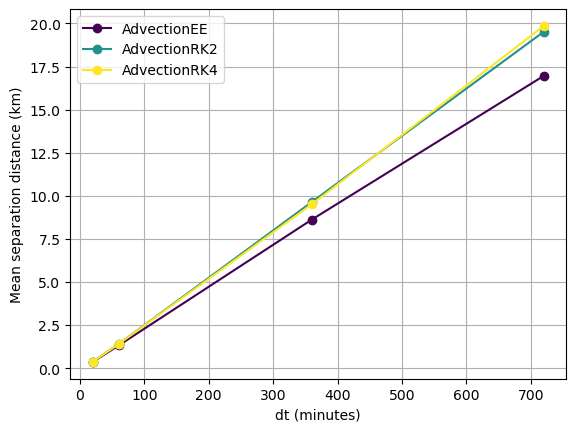

In [52]:
fig = plt.figure()
ax=plt.axes()
for i, advection_scheme in enumerate(advection_schemes):
    ax.plot((dt_choices[:-1]/np.timedelta64(1,"m")).astype(int), np.mean(dist_end[:,i],axis=1), "-o", color=plt.cm.viridis(scheme_colours[i]), label = f"{advection_scheme.__name__}")
ax.set_ylabel("Mean separation distance (km)")
ax.set_xlabel("dt (minutes)")
ax.legend()
ax.grid()
plt.show()